In [42]:
from torch_geometric.datasets import Planetoid
import torch_geometric.utils as pyg_utils
import networkx as nx
import matplotlib.pyplot as plt
import torch

import torch_geometric.transforms as T

In [43]:
# the [0] at the end is used to access the attributes
data = Planetoid('./data/Cora', 'Cora', transform=T.NormalizeFeatures())[0]

In [44]:
# Define the dataset name ('Cora', 'CiteSeer', or 'PubMed')
dataset_name = 'Cora'

# Load the dataset
dataset = Planetoid(root='./data', name=dataset_name)

# Access the dataset attributes
data = dataset[0]

In [45]:
data_details = {
    "num_nodes" : data.num_nodes, 
    "num_edges" : data.num_edges, 
    "num_edge_features": dataset.num_edge_features,
    "num_node_features": dataset.num_node_features,
    "num_node_classes": dataset.num_classes   
}

print(data_details)

{'num_nodes': 2708, 'num_edges': 10556, 'num_edge_features': 0, 'num_node_features': 1433, 'num_node_classes': 7}


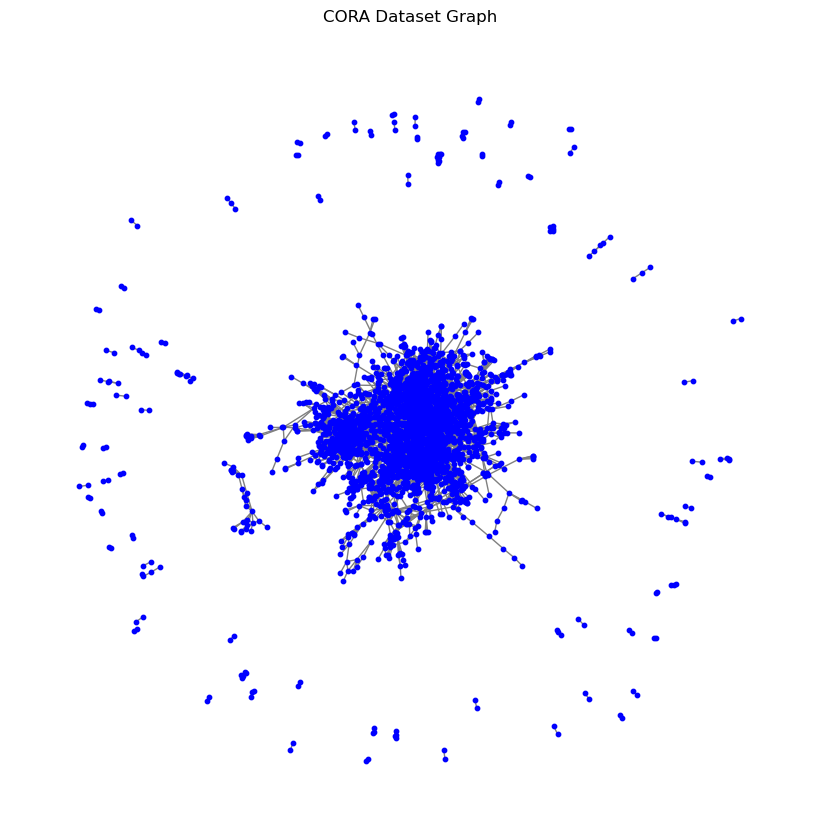

In [46]:
# Convert PyTorch Geometric data to NetworkX graph ---
graph = pyg_utils.to_networkx(data, to_undirected=True)

# Draws the graph ----
plt.figure(figsize=(8, 8))
nx.draw(graph, node_size=10, node_color='b', edge_color='gray', with_labels=False)
plt.title('CORA Dataset Graph')
plt.show()

# AnomalyDAE (Anomaly Detection Autoencoder) model


In [47]:
from pygod.generator import gen_contextual_outlier, gen_structural_outlier

# introduces anomalies (posion) to the train data bc the original dataset didnt have any
data, ya = gen_contextual_outlier(data, n=100, k=50)
data, ys = gen_structural_outlier(data, m=10, n=10)
data.y = torch.logical_or(ys, ya).long()


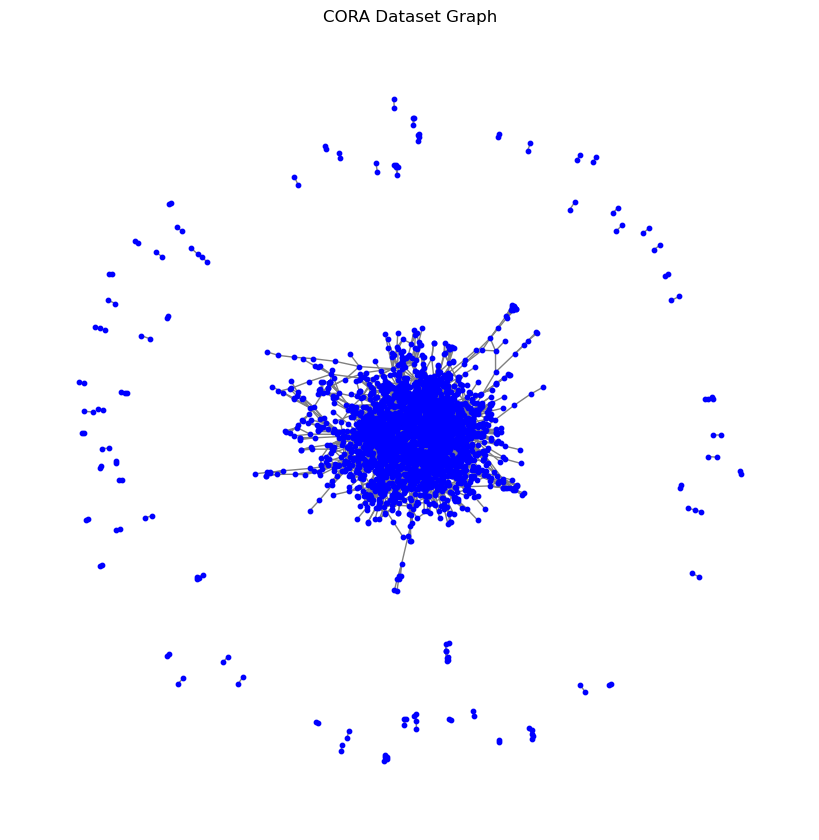

In [48]:
# Convert PyTorch Geometric data to NetworkX graph ---
graph2 = pyg_utils.to_networkx(data, to_undirected=True)

# Draws the graph ----
plt.figure(figsize=(8, 8))
nx.draw(graph2, node_size=10, node_color='b', edge_color='gray', with_labels=False)
plt.title('CORA Dataset Graph')
plt.show()

In [49]:
from torch.nn import Sigmoid
from pygod import detector
from pygod.detector import AnomalyDAE

import torch.nn.functional as F
from pygod.detector import DeepDetector
from pygod.nn import AnomalyDAEBase

In [50]:
from pygod.detector import AnomalyDAE
import torch.sparse 

# instance of anomalyDAE model from library
model = AnomalyDAE()

# fit the model to the data we introduced anomalies to
model.fit(data=data)

AnomalyDAE(act=<function relu at 0x000001FD4EE21280>, alpha=0.5,
           backbone=None, batch_size=2708, compile_model=False,
           contamination=0.1, dropout=0.0, emb_dim=64, epoch=5, eta=1.0,
           gpu=None, hid_dim=64, lr=0.004, num_layers=4,
           num_neigh=[-1, -1, -1, -1], save_emb=False, theta=1.0,
           verbose=0, weight_decay=0.0)

In [51]:
## predictions for anomalyDAE
pred, score, prob, conf = model.predict(data,
                                                return_pred=True,
                                                return_score=True,
                                                return_prob=True,
                                                return_conf=True)

In [52]:
print(pred[11], prob[11], conf[11]) # prints prediction for outlier (1=outlier), probability of it being an outlier, and confidence

tensor(1) tensor(0.8308) tensor(1.)


In [85]:
node_colors = []
# assign red to outliers and blue to regular, based on predictions
# for i in range(pred.numel()):
#     if pred[i].item() == 1: 
#         node_colors.append('red')
#     else:
#         node_colors.append('blue')

# assign colors based on probability of being an outlier
for i in range(pred.numel()):
    if prob[i].item() > 0.9: 
        node_colors.append('red')
    elif prob[i].item() > 0.8:
        node_colors.append('orange')
    elif prob[i].item() > 0.75:
        node_colors.append('yellow')
    else:
        node_colors.append('blue')

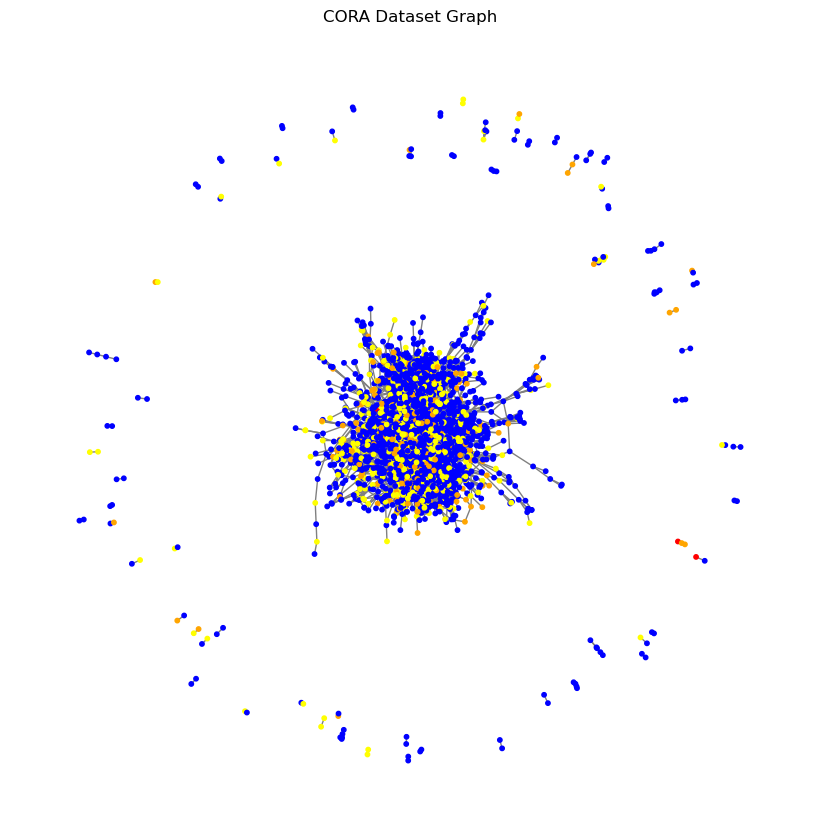

In [86]:
# Convert PyTorch Geometric data to NetworkX graph ---
graph3 = pyg_utils.to_networkx(data, to_undirected=True)

# Draws the graph ----
plt.figure(figsize=(8, 8))
nx.draw(graph3, node_size=10, node_color=node_colors, edge_color='gray', with_labels=False)
plt.title('CORA Dataset Graph')
plt.show()